In [ ]:
#|default_exp activations

# Activation stats

These were directly copied from the corresponding notebook.

In [ ]:
#|export
from __future__ import annotations
import random,math,torch,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from functools import partial

from miniai.datasets import *
from miniai.learner import *

In [ ]:
import torch.nn.functional as F,matplotlib as mpl
from pathlib import Path
from operator import attrgetter,itemgetter
from contextlib import contextmanager

from torch import tensor,nn,optim
import torchvision.transforms.functional as TF
from datasets import load_dataset

from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['figure.constrained_layout.use'] = True

import logging
logging.disable(logging.WARNING)

In [ ]:
#| export
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)

In [ ]:
x, y = "image", "label"
name = "fashion_mnist"
ds = load_dataset(name)
@inplace
def transformi(b):
    b[x] = [TF.to_tensor(i) for i in b[x]]
dst = ds.with_transform(transformi)

bs = 1024
dls = DataLoaders.from_dd(dst, bs)
b = next(iter(dls.train))

## Baseline

In [ ]:
from miniai.conv import conv

In [ ]:
def get_layers():
    return [conv(1,8), conv(8,16), conv(16,32), conv(32,64), conv(64,10, act=False), nn.Flatten()]

def get_model():
    return nn.Sequential(*get_layers())

In [ ]:
b[0].shape

torch.Size([1024, 1, 28, 28])

In [ ]:
get_model()(b[0][:16]).shape

torch.Size([16, 10])

In [ ]:
from torcheval.metrics import MulticlassAccuracy

In [ ]:
cbs = [TrainCB(), DeviceCB(), MetricsCB(accuracy=MulticlassAccuracy()), ProgressCB(True)]

In [ ]:
def fit(model, epochs=1, cbs_extra=None):
    cbs_to_use = cbs
    if cbs_extra:
        cbs_to_use = cbs + cbs_extra
    learn = Learner(model, dls, F.cross_entropy, 0.95, cbs_to_use, optim.SGD)
    learn.fit(epochs)
    return learn

accuracy,loss,epoch,train
0.187,2.246,0,train
0.118,2.321,0,valid


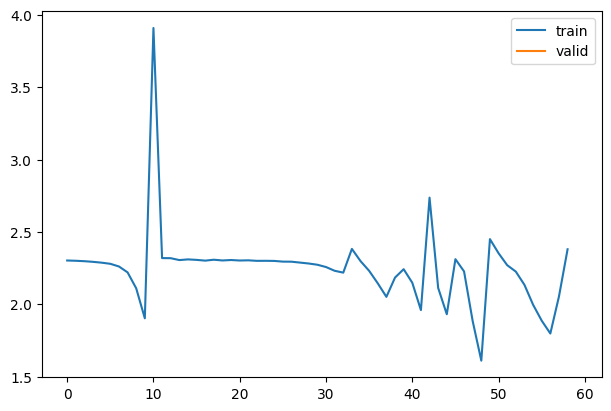

In [ ]:
set_seed(1103)
fit(get_model());

## Hooks

### Manual insertion

In [ ]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.means = [[] for i in range(len(self.layers))]
        self.stds = [[] for i in range(len(self.layers))]

    def forward(self, x):
        for i, l in enumerate(self.layers):
            x = l(x)
            self.means[i].append(to_cpu(x.mean()))
            self.stds[i].append(to_cpu(x.std()))
        return x

accuracy,loss,epoch,train
0.187,2.246,0,train
0.118,2.321,0,valid


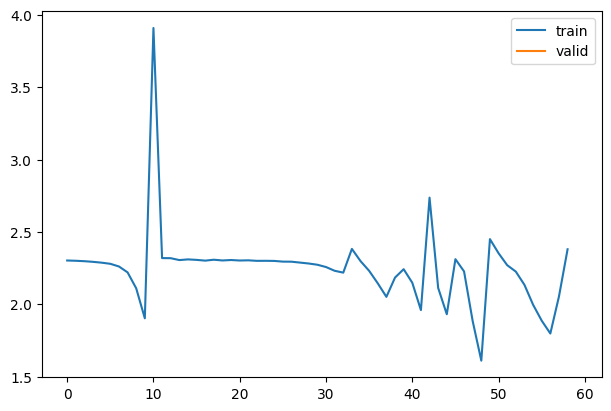

In [ ]:
set_seed(1103)
model = SequentialModel(get_layers())
fit(model, 1);

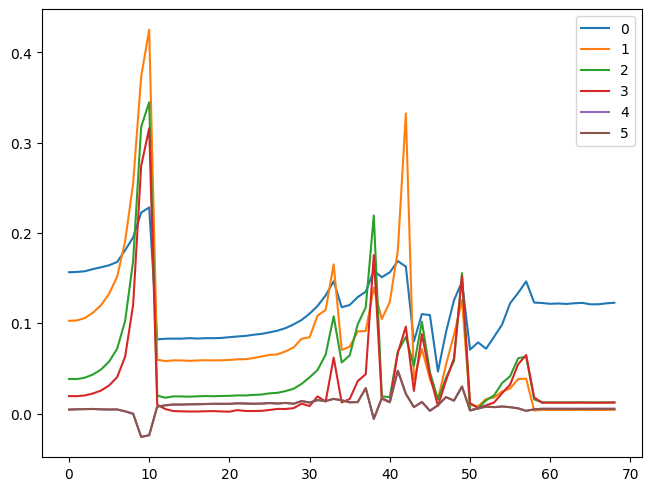

In [ ]:
for i, m in enumerate(model.means):
    plt.plot(m, label=i)
plt.legend();

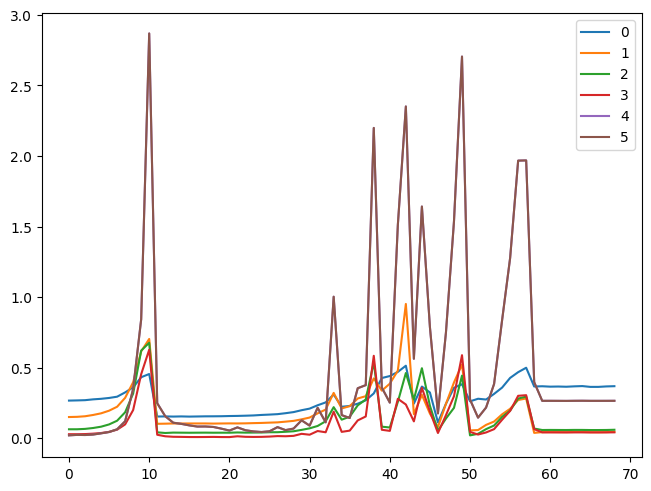

In [ ]:
for i, m in enumerate(model.stds):
    plt.plot(m, label=i)
plt.legend();

### PyTorch hooks

In [ ]:
set_seed(1103)
model = get_model()

In [ ]:
act_means = [[] for i in model]
act_stds = [[] for i in model]

In [ ]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(to_cpu(outp.mean()))
    act_stds[i].append(to_cpu(outp.std()))

In [ ]:
for i, m in enumerate(model):
    m.register_forward_hook(partial(append_stats, i))

accuracy,loss,epoch,train
0.187,2.246,0,train
0.118,2.321,0,valid


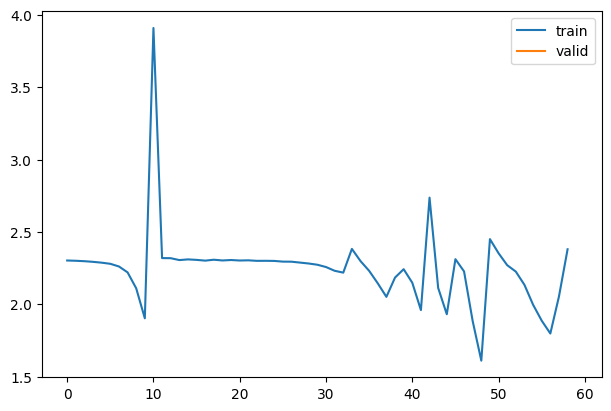

In [ ]:
fit(model);

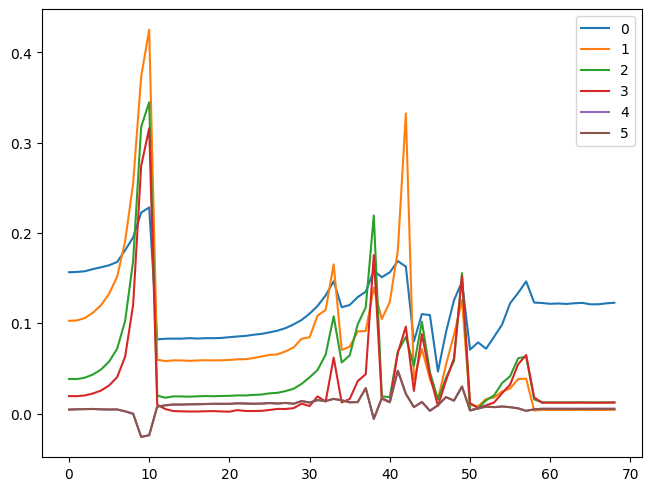

In [ ]:
for i, m in enumerate(act_means):
    plt.plot(m, label=i)
plt.legend();

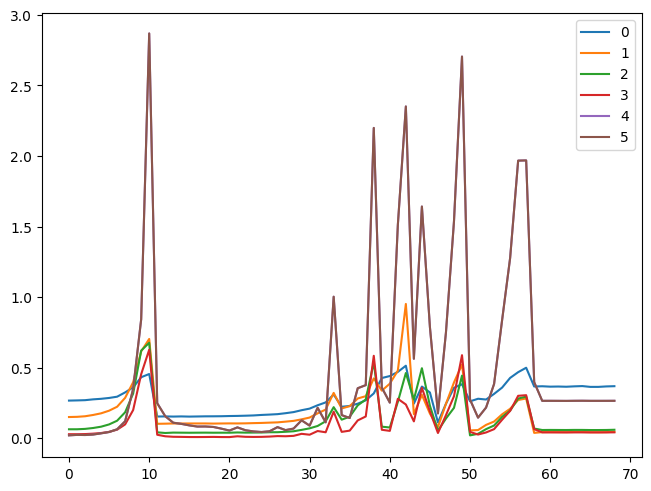

In [ ]:
for i, m in enumerate(act_stds):
    plt.plot(m, label=i)
plt.legend();

### Hook class

In [ ]:
def dummy(mod, inp, outp): ...

hook = model[0].register_forward_hook(dummy)

In [ ]:
list(filter(lambda x: x[0]!='_', dir(hook)))

['extra_dict_ref', 'hooks_dict_ref', 'id', 'next_id', 'remove']

In [ ]:
#| export
class Hook:
    def __init__(self, m, f):
        self.hook = m.register_forward_hook(partial(f, self))

    def remove(self):
        self.hook.remove()

    def __del__(self):
        self.remove()

In [ ]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, "stats"):
        hook.stats = ([], [])
    with torch.no_grad():
        hook.stats[0].append(to_cpu(outp.mean()))
        hook.stats[1].append(to_cpu(outp.std()))

In [ ]:
set_seed(1103)
model = get_model()

In [ ]:
hooks = [Hook(m, append_stats) for m in model]

accuracy,loss,epoch,train
0.187,2.246,0,train
0.118,2.321,0,valid


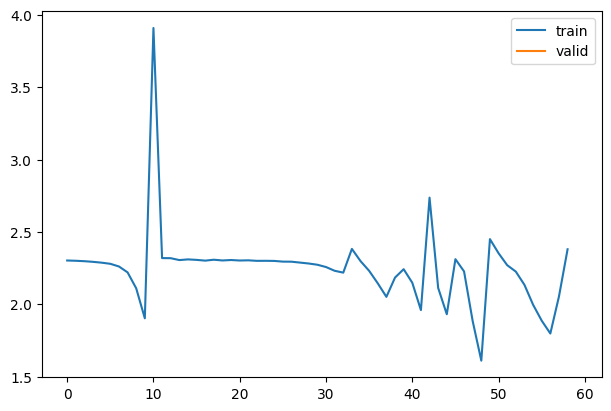

In [ ]:
fit(model);

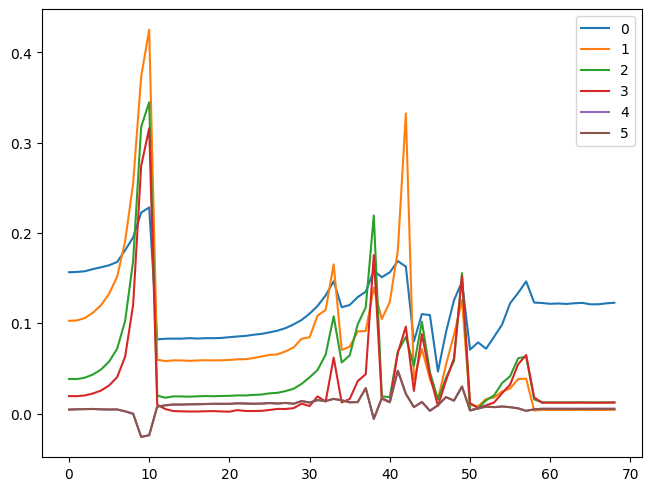

In [ ]:
for i, h in enumerate(hooks):
    plt.plot(h.stats[0], label=i)
plt.legend();

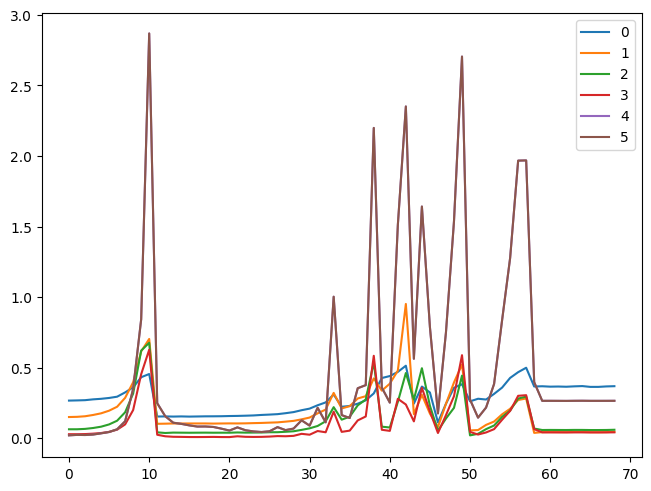

In [ ]:
for i, h in enumerate(hooks):
    plt.plot(h.stats[1], label=i)
plt.legend();

### A Hooks class

In [ ]:
#| export
class Hooks(list):
    def __init__(self, ms, f):
        super().__init__([Hook(m, f) for m in ms])

    def __enter__(self, *args):
        return self

    def __exit__(self, *args):
        self.remove()

    def __del__(self):
        self.remove()

    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)

    def remove(self):
        for h in self:
            h.remove()

In [ ]:
set_seed(1103)
model = get_model()

accuracy,loss,epoch,train
0.187,2.246,0,train
0.118,2.321,0,valid


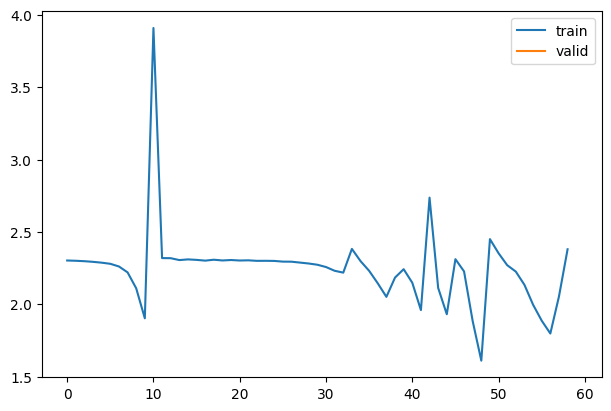

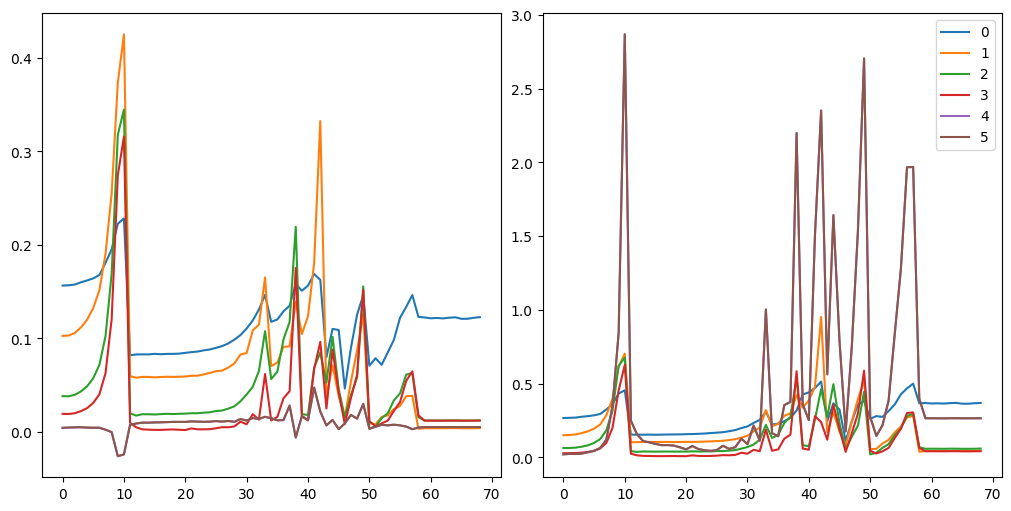

In [ ]:
with Hooks(model, append_stats) as hooks:
    fit(model)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    for h in hooks:
        for i in range(2):
            ax[i].plot(h.stats[i])
    plt.legend(range(len(hooks)))        

In [ ]:
list(model.modules())

[Sequential(
   (0): Sequential(
     (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
     (1): ReLU()
   )
   (1): Sequential(
     (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
     (1): ReLU()
   )
   (2): Sequential(
     (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
     (1): ReLU()
   )
   (3): Sequential(
     (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
     (1): ReLU()
   )
   (4): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (5): Flatten(start_dim=1, end_dim=-1)
 ),
 Sequential(
   (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): ReLU()
 ),
 Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
 ReLU(),
 Sequential(
   (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): ReLU()
 ),
 Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
 ReLU(),
 Sequential(
   (0): Conv2d(16, 32, ker

In [ ]:
#| export
class HooksCallback(Callback):
    def __init__(self, hookfunc, mod_filter=fc.noop):
        fc.store_attr()
        super().__init__()
    
    def before_fit(self, learn):
        modules = filter(self.mod_filter, learn.model.modules())
        self.hooks = Hooks(modules, self.hookfunc)

    def after_fit(self, learn):
        self.hooks.remove()

    def __iter__(self):
        return iter(self.hooks)

    def __len__(self):
        return len(self.hooks)

accuracy,loss,epoch,train
0.187,2.246,0,train
0.118,2.321,0,valid


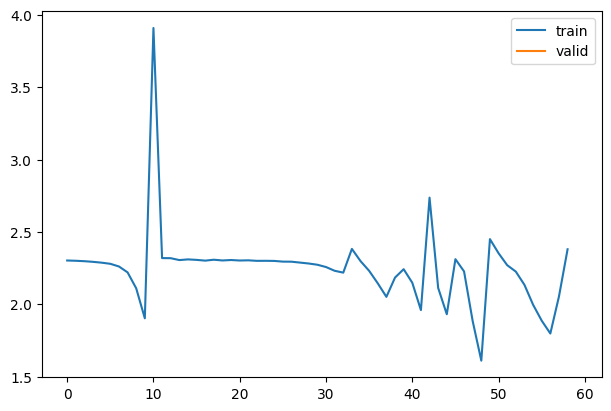

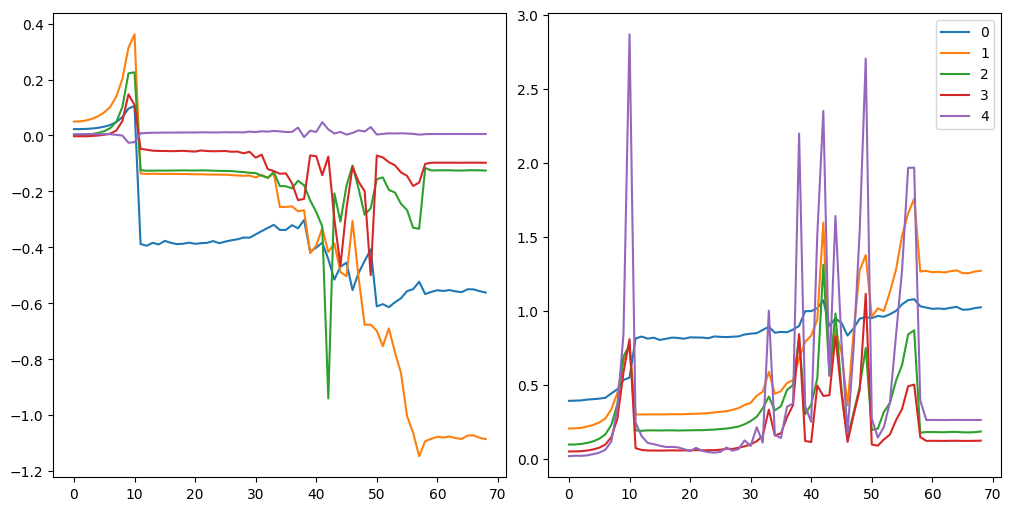

In [ ]:
set_seed(1103)
model = get_model()
hooks = HooksCallback(append_stats, lambda x: isinstance(x, nn.Conv2d))
fit(model, cbs_extra=[hooks])
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for h in hooks:
    for i in range(2):
        ax[i].plot(h.stats[i])
plt.legend(range(len(hooks)));

## Histograms

In [ ]:
list(filter(lambda x: x.find("hist") != -1, dir(torch.Tensor)))

['histc', 'histogram']

In [ ]:
torch.Tensor.histc?

Docstring:
histc(bins=100, min=0, max=0) -> Tensor

See :func:`torch.histc`
Type:      method_descriptor

In [ ]:
torch.Tensor.histogram?

Docstring:
histogram(input, bins, *, range=None, weight=None, density=False) -> (Tensor, Tensor)

See :func:`torch.histogram`
Type:      method_descriptor

In [ ]:
#| export
def append_stats(hook, mod, inp, outp, bins=30, min=0, max=10):
    if not hasattr(hook, "stats"):
        hook.stats = ([], [], [])
    with torch.no_grad():
        hook.stats[0].append(to_cpu(outp.mean()))
        hook.stats[1].append(to_cpu(outp.std()))
        hook.stats[2].append(to_cpu(outp).abs().histc(bins, min, max))

accuracy,loss,epoch,train
0.187,2.246,0,train
0.118,2.321,0,valid


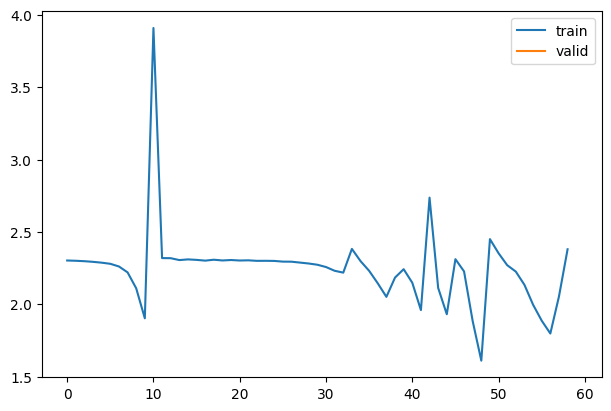

In [ ]:
set_seed(1103)
model = get_model()
with Hooks(model, append_stats) as hooks:
    fit(model)

In [ ]:
h = hooks[0]
av = h.stats[2]

In [ ]:
len(av), av[0].shape

(69, torch.Size([30]))

In [ ]:
avs = torch.stack(av)
avs.shape

torch.Size([69, 30])

In [ ]:
show_image

<function miniai.datasets.show_image(im, ax=None, figsize=None, title=None, *, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None)>

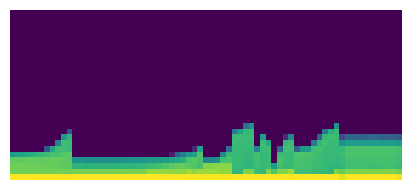

In [ ]:
show_image(avs.T.log1p(), figsize=(4,4), origin="lower");

In [ ]:
#| export
def get_hist(h):
    return torch.stack(h.stats[2]).T.log1p()

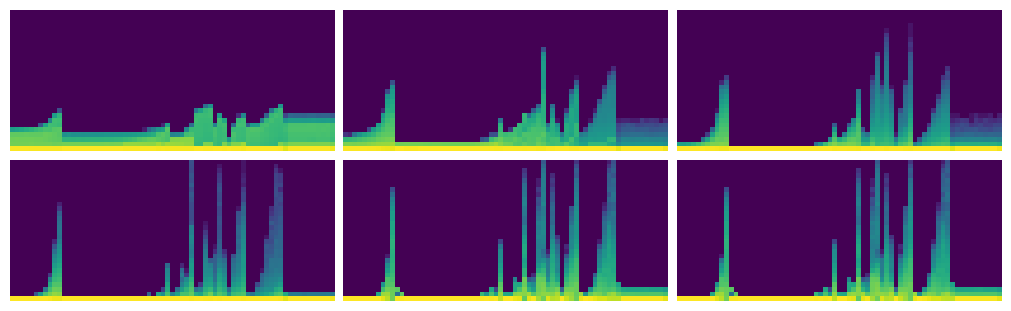

In [ ]:
fig, ax = get_grid(len(hooks), figsize=(10, 3))
for ax, h in zip(ax.flat, hooks):
    show_image(get_hist(h), ax, origin="lower")

In [ ]:
#| export
def get_min(h):
    hist = get_hist(h)
    return hist[0:1].sum(axis=0) / hist.sum(axis=0)

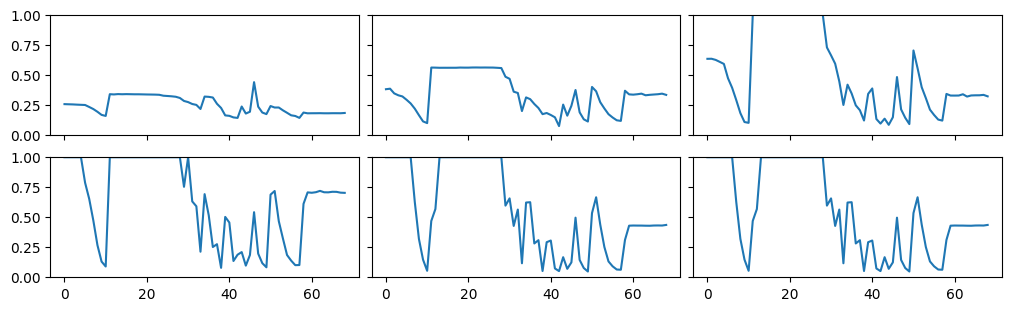

In [ ]:
fig, ax = get_grid(len(hooks), figsize=(10, 3), sharey=True, sharex=True)
for ax, h in zip(ax.flat, hooks):
    ax.plot(get_min(h))
    ax.set_ylim(0, 1)
    ax.set_axis_on()

In [ ]:
#| export
class ActivationStats(HooksCallback):
    def __init__(self, mod_filter=fc.noop):
        super().__init__(append_stats, mod_filter)

    def color_dim(self, figsize=(10, 3)):
        fig, ax = get_grid(len(self), figsize=figsize)
        for ax, h in zip(ax.flat, self):
            show_image(get_hist(h), ax, origin="lower")

    def dead_chart(self, figsize=(10, 3)):
        fig, ax = get_grid(len(self), figsize=figsize, sharey=True, sharex=True)
        for ax, h in zip(ax.flat, self):
            ax.plot(get_min(h))
            ax.set_ylim(0, 1)
            ax.set_axis_on()

    def plot_stats(self, figsize=(10, 3)):
        fig, ax = plt.subplots(1, 2, figsize=figsize)
        for h in self:
            for i in range(2):
                ax[i].plot(h.stats[i])
        ax[0].set_title("Means")
        ax[1].set_title("Stds")
        plt.legend(range(len(self)))

accuracy,loss,epoch,train
0.187,2.246,0,train
0.118,2.321,0,valid


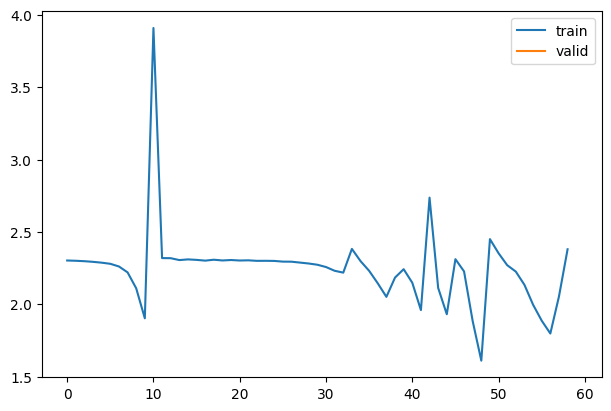

In [ ]:
set_seed(1103)
model = get_model()
stats = ActivationStats(lambda x: isinstance(x, nn.Conv2d))
fit(model, cbs_extra=[stats]);

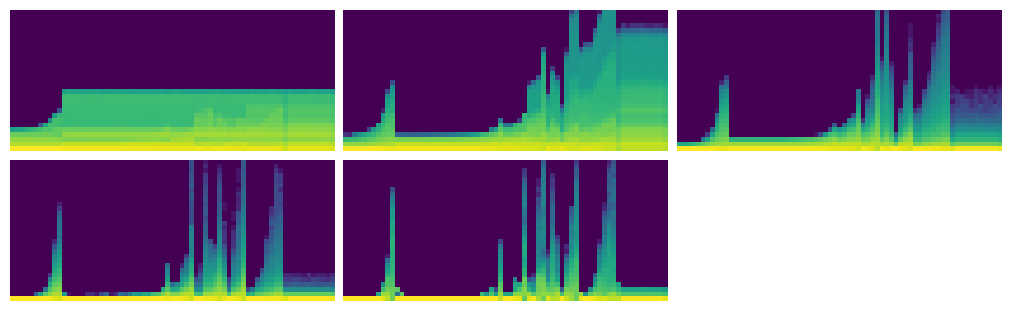

In [ ]:
stats.color_dim()

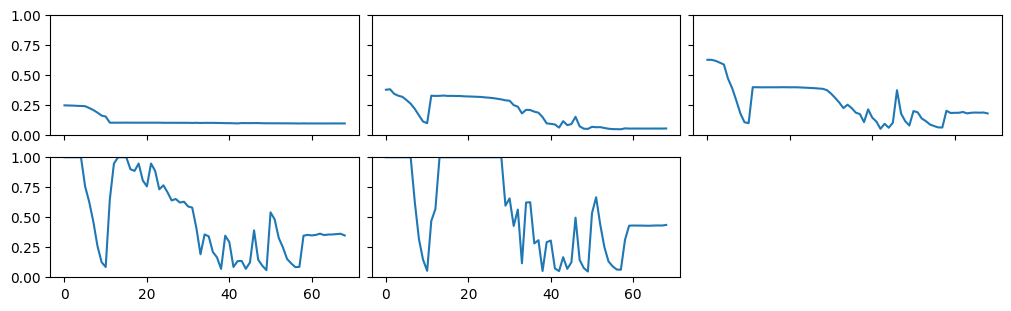

In [ ]:
stats.dead_chart()

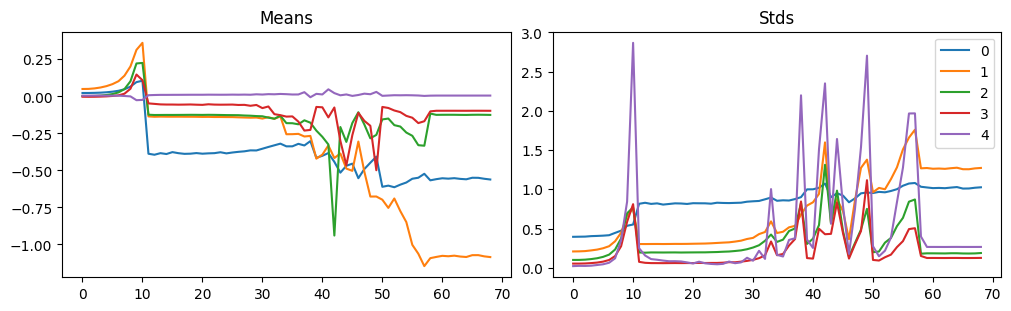

In [ ]:
stats.plot_stats()

# Export

In [ ]:
import nbdev; nbdev.nbdev_export()